In [25]:
import skimage as skimg
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

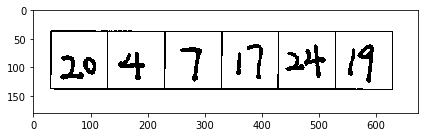

In [9]:

img = io.imread('./data/table1.jpg', True)
# io.imshow(img)

#二值化
bi_th = 0.9
img[img <= bi_th] = 0
img[img > bi_th] = 1
io.imshow(img)


In [22]:
# 膨胀腐蚀操作
def dil2ero(img, selem):
    img = skimg.morphology.dilation(img, selem)
    imgres = skimg.morphology.erosion(img, selem)
    return imgres


# 求图像中的横线和竖线
rows, cols = img.shape
scale = 10

col_selem = skimg.morphology.rectangle(cols//scale, 1)
img_cols = dil2ero(img, col_selem)

row_selem = skimg.morphology.rectangle(1, rows//scale)
img_rows = dil2ero(img, row_selem)


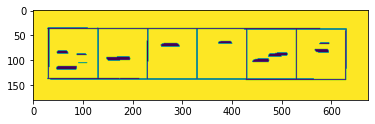

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [23]:
# 线图
img_line = img_cols*img_rows
plt.imshow(img_line)
plt.show()
io.imsave("table.jpg", img_line)

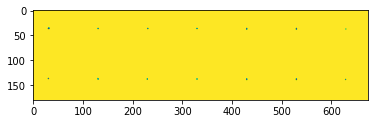

In [24]:
# 点图
img_dot = img_cols+img_rows
img_dot[img_dot > 0] = 1
plt.imshow(img_dot)
plt.show()


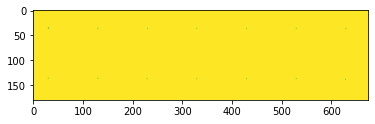

In [26]:
def isolate(imgdot):
    idx = np.argwhere(imgdot < 1)  # img值小于1的索引数组
    rows, cols = imgdot.shape

    for i in range(idx.shape[0]):
        c_row = idx[i, 0]
        c_col = idx[i, 1]
        if c_col+1 < cols and c_row+1 < rows:
            imgdot[c_row, c_col+1] = 1
            imgdot[c_row+1, c_col] = 1
            imgdot[c_row+1, c_col+1] = 1
        if c_col+2 < cols and c_row+2 < rows:
            imgdot[c_row+1, c_col+2] = 1
            imgdot[c_row+2, c_col] = 1
            imgdot[c_row, c_col+2] = 1
            imgdot[c_row+2, c_col+1] = 1
            imgdot[c_row+2, c_col+2] = 1
    return imgdot


img_dot = isolate(img_dot)
plt.imshow(img_dot)
plt.show()

(180, 674)

In [4]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread('./data/table/table2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(
    binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

draw_img0 = cv2.drawContours(img.copy(), contours, 0, (0, 255, 255), 3)
draw_img1 = cv2.drawContours(img.copy(), contours, 1, (255, 0, 255), 3)
draw_img2 = cv2.drawContours(img.copy(), contours, 2, (255, 255, 0), 3)
draw_img3 = cv2.drawContours(img.copy(), contours, -1, (0, 0, 255), 3)

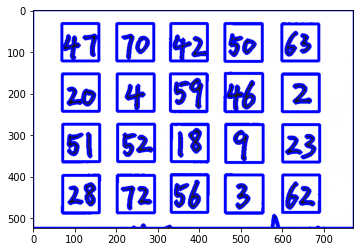

In [8]:
plt.imshow(draw_img3)


In [1]:
import numpy as np
import cv2 as cv
import os
# 设置putText函数字体
font = cv.FONT_HERSHEY_SIMPLEX
#计算两边夹角额cos值


def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs(np.dot(d1, d2) / np.sqrt(np.dot(d1, d1)*np.dot(d2, d2)))


def find_squares(img):
    squares = []
    img = cv.GaussianBlur(img, (3, 3), 0)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    bin = cv.Canny(gray, 30, 100, apertureSize=3)
    contours, _hierarchy = cv.findContours(
        bin, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    index = 0
    # 轮廓遍历
    centers = []
    for cnt in contours:
        cnt_len = cv.arcLength(cnt, True)  # 计算轮廓周长
        cnt = cv.approxPolyDP(cnt, 0.02*cnt_len, True)  # 多边形逼近
        # 条件判断逼近边的数量是否为4，轮廓面积是否大于1000，检测轮廓是否为凸的
        if len(cnt) == 4 and cv.contourArea(cnt) > 1000 and cv.isContourConvex(cnt):
            M = cv.moments(cnt)  # 计算轮廓的矩
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])  # 轮廓重心

            cnt = cnt.reshape(-1, 2)
            max_cos = np.max(
                [angle_cos(cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4]) for i in range(4)])
            # 只检测矩形（cos90° = 0）
            if max_cos < 0.1:
                # 检测四边形（不限定角度范围）
                index = index + 1
                # cv.putText(img, ("#%d" % index), (cx, cy),
                #            font, 0.7, (255, 0, 255), 2)
                x1, x2 = np.min(cnt[:, 0]), np.max(cnt[:, 0])
                y1, y2 = np.min(cnt[:, 1]), np.max(cnt[:, 1])
                x1, y1, x2, y2 = list(map(int, [x1, y1, x2, y2]))
                cnt = [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
                squares.append(cnt)
                centers.append([cx, cy])

    
    return squares, centers, img





In [30]:
img = cv2.imread('./data/table/table2.jpg')
# img = cv2.imread('./data/table/table1.jpg')
squares, centers, img = find_squares(img)
centers = np.array(centers, dtype=np.int64)
centers_squares_map = {','.join(map(str, pt)): sqr
					for pt, sqr in zip(centers, squares)}

In [40]:
centers_squares_map

{'644,441': [[599, 395], [689, 395], [689, 487], [599, 487]],
 '247,442': [[201, 396], [293, 396], [293, 488], [201, 488]],
 '115,442': [[70, 396], [160, 396], [160, 488], [70, 488]],
 '507,441': [[461, 395], [553, 395], [553, 488], [461, 488]],
 '376,441': [[331, 395], [421, 395], [421, 487], [331, 487]],
 '644,319': [[599, 274], [690, 274], [690, 366], [599, 366]],
 '507,320': [[462, 274], [554, 274], [554, 367], [462, 367]],
 '376,319': [[331, 273], [422, 273], [422, 365], [331, 365]],
 '247,319': [[202, 273], [293, 273], [293, 365], [202, 365]],
 '115,319': [[70, 273], [161, 273], [161, 365], [70, 365]],
 '643,198': [[598, 153], [689, 153], [689, 245], [598, 245]],
 '374,198': [[329, 152], [419, 152], [419, 244], [329, 244]],
 '246,198': [[201, 152], [292, 152], [292, 244], [201, 244]],
 '114,198': [[69, 152], [160, 152], [160, 244], [69, 244]],
 '506,197': [[461, 151], [553, 151], [553, 245], [461, 245]],
 '642,77': [[597, 32], [688, 32], [688, 123], [597, 123]],
 '506,77': [[460,

In [33]:
a = copy.copy(centers)
sorted_squares = [','.join(map(str, sortCT)) 
				 for sortCT in sorted(a, key=lambda k: [k[1], k[0]])]

In [37]:
sorted_squares

['113,77',
 '245,77',
 '374,77',
 '506,77',
 '642,77',
 '506,197',
 '114,198',
 '246,198',
 '374,198',
 '643,198',
 '115,319',
 '247,319',
 '376,319',
 '644,319',
 '507,320',
 '376,441',
 '507,441',
 '644,441',
 '115,442',
 '247,442']

In [42]:
i = 0
for row in range(4):
	for col in range(5):
		ct = sorted_squares[i]
		i += 1
		rw, cl = str(row), str(col)
		imgn = rw + '_' + cl + '.jpg'
		imgp = os.path.join('./data/table/rectangle/', imgn)
		loc = centers_squares_map[ct]
		x1, y1, x2, y2 = loc[0][0], loc[0][1], loc[2][0], loc[2][1]
		block_img = img[y1:y2, x1:x2, :]
		cv2.imwrite(imgp, block_img)


In [17]:
import copy
import cv2


for i, loc in enumerate(squares):
	x1, y1, x2, y2 = loc[0][0], loc[0][1], loc[2][0], loc[2][1]
	block = img[y1:y2, x1:x2, :]
	raw, col = indexY[i] , indexX[i]
	cx, cy = centers[i]
	# pt = '-{:d}-{:d}'.format(cx, cy)
	# imgn = str(raw) + str('_') + str(col) + pt +'.jpg'
	imgn = str(raw // 5) + str('_') + str(col // 4) +'.jpg'
	imgp = os.path.join('./data/table/rectangle', imgn)
	cv2.imwrite(imgp, block)
	# print('矩形数:', len(squares))
	# cv.drawContours(img, squares, -1, (0, 0, 255), 2)
	# plt.imshow(img)
	# plt.show()
